Tidal Constituents: ['Q1', 'O1', 'P1', 'K1', 'N2', 'M2', 'S2', 'K2']


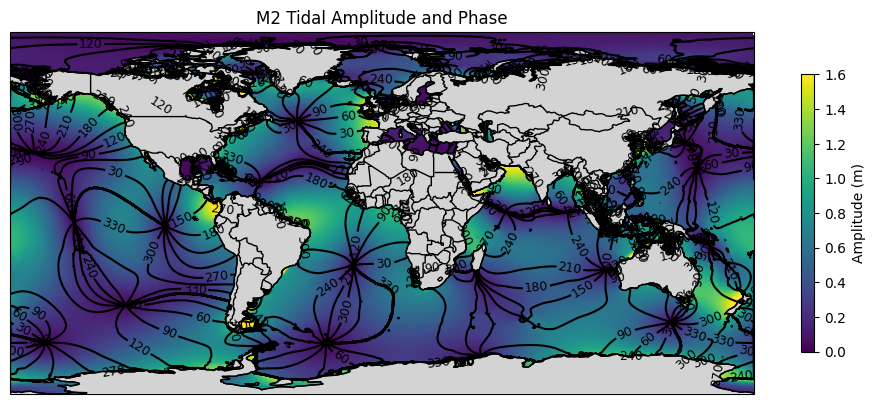

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.tri import Triangulation

# Load the NetCDF file
file_path = "/scratch/07174/soelem/global_test_4-20km/fort.53.nc"
ds = xr.open_dataset(file_path)

# Print the available tidal constituents
constituents = [''.join(c.decode('utf-8')).strip() for c in ds['const'].values]
print("Tidal Constituents:", constituents)

# Set the tidal constituent index (M2 is typically index 5)
m2_index = 5  # You can change this index to test other constituents if needed

# Extract relevant data for the selected tidal constituent (M2 in this case)
lats = ds['y'].values
lons = ds['x'].values
amplitude = ds['amp'][:, m2_index].values
phase = ds['phs'][:, m2_index].values

# Handle _FillValue (-99999.0) by replacing it with NaN
amplitude = np.where(amplitude == -99999.0, np.nan, amplitude)
phase = np.where(phase == -99999.0, np.nan, phase)

# Filter valid points only
valid_mask = np.isfinite(amplitude) & np.isfinite(phase) & np.isfinite(lats) & np.isfinite(lons)
lats_valid = lats[valid_mask]
lons_valid = lons[valid_mask]
amplitude_valid = amplitude[valid_mask]
phase_valid = phase[valid_mask]

# If there are fewer than 3 valid points, triangulation will fail
if len(lons_valid) < 3:
    raise ValueError("Not enough valid points for triangulation!")

# Create the triangulation using the valid points
triang = Triangulation(lons_valid, lats_valid)

# Define the map projection
proj = ccrs.PlateCarree()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': proj})

# Plot the amplitude using tripcolor
sc = ax.tripcolor(triang, amplitude_valid, cmap='viridis', transform=proj, vmin=0, vmax=1.6, zorder=1)

# Add phase contours using tricontour
contour = ax.tricontour(triang, phase_valid, levels=np.arange(0, 360, 30), colors='black', transform=proj, zorder=2)
ax.clabel(contour, fontsize=9, inline=1)

# Add land features on top of the contour lines to mask them over land
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=3)

# Add coastlines and other map features with a higher zorder than contours
ax.coastlines(resolution='110m', zorder=4)

# Set the extent to the global view
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=proj)

# Add a colorbar for amplitude
plt.colorbar(sc, ax=ax, shrink=0.6, label='Amplitude (m)')

# Add title
ax.set_title(f'{constituents[m2_index]} Tidal Amplitude and Phase')

# Show the plot
plt.show()